<a href="https://colab.research.google.com/github/srigstinahf/Prediksi-RNN-LSTM-TFT-/blob/main/TFT_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 10/100 - Train Loss: 0.1552 - Val Loss: 0.2600
Epoch 20/100 - Train Loss: 0.0364 - Val Loss: 0.0196
Epoch 30/100 - Train Loss: 0.0298 - Val Loss: 0.0477
Epoch 40/100 - Train Loss: 0.0315 - Val Loss: 0.0538
Epoch 50/100 - Train Loss: 0.0274 - Val Loss: 0.0247
Epoch 60/100 - Train Loss: 0.0234 - Val Loss: 0.0349
Epoch 70/100 - Train Loss: 0.0193 - Val Loss: 0.0211
Epoch 80/100 - Train Loss: 0.0144 - Val Loss: 0.0187
Epoch 90/100 - Train Loss: 0.0105 - Val Loss: 0.0144
Epoch 100/100 - Train Loss: 0.0108 - Val Loss: 0.0158


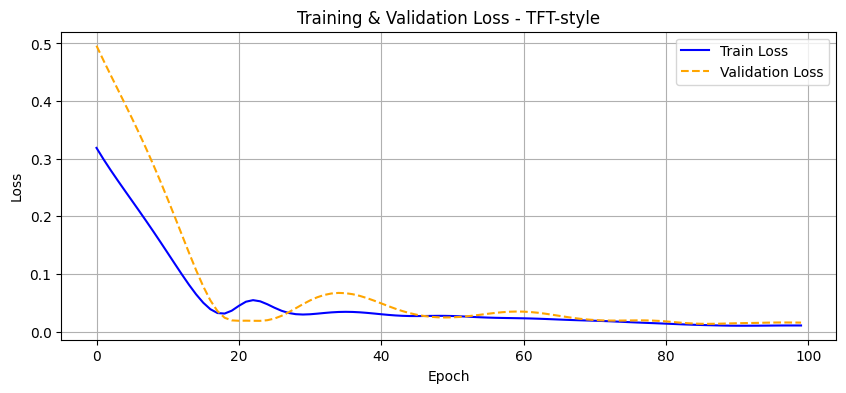


📊 Evaluation on Test Set (TFT-style):
MAE  = 2.9762
RMSE = 3.8147
MAPE = 22.06%


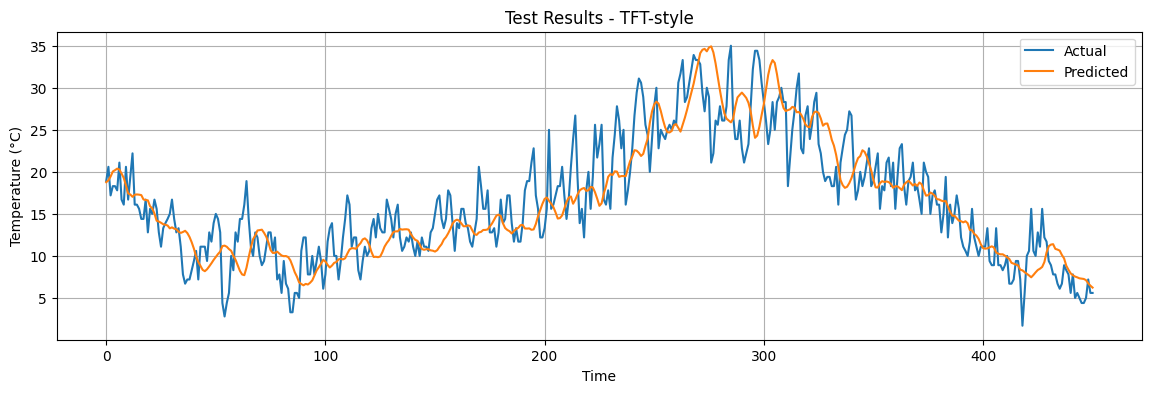

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('sample_data/dataset seattle-weather.csv')
df.dropna(inplace=True)
df['date'] = pd.to_datetime(df['date'])

#Scaling
scaler = MinMaxScaler()
df['temp_max_scaled'] = scaler.fit_transform(df[['temp_max']])

#Sliding Window
def df_to_XY(series, window=10):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

WINDOW = 10
series = df['temp_max_scaled'].values
X, y = df_to_XY(series, WINDOW)

#Split Data
X_train, y_train = X[:800], y[:800]
X_val, y_val = X[800:1000], y[800:1000]
X_test, y_test = X[1000:], y[1000:]

#Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

#Build TFT model
class TFTBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TFTBlock, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.attn = nn.MultiheadAttention(hidden_size, num_heads=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out)
        out = self.fc(attn_out[:, -1, :])
        return out

model = TFTBlock(input_size=1, hidden_size=50)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Logging Loss
train_losses = []
val_losses = []

#Training
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()

    #Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = loss_fn(val_output, y_val).item()

    train_losses.append(loss.item())
    val_losses.append(val_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange', linestyle='--')
plt.title("Training & Validation Loss - TFT-style")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

#Prediction
model.eval()
pred_train = model(X_train).detach().numpy().flatten()
pred_val = model(X_val).detach().numpy().flatten()
pred_test = model(X_test).detach().numpy().flatten()

pred_all = np.concatenate([pred_train, pred_val, pred_test])
actual_all = series[WINDOW:]

#Invers transform
actual_inv = scaler.inverse_transform(actual_all.reshape(-1, 1)).flatten()
pred_inv = scaler.inverse_transform(pred_all.reshape(-1, 1)).flatten()

#Evaluasi Metrik
mae = mean_absolute_error(actual_inv[1000:], pred_inv[1000:])
rmse = np.sqrt(mean_squared_error(actual_inv[1000:], pred_inv[1000:]))
mape = np.mean(np.abs((actual_inv[1000:] - pred_inv[1000:]) / actual_inv[1000:])) * 100

print(f"\n📊 Evaluation on Test Set (TFT-style):")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")

plt.figure(figsize=(14, 4))
plt.title("Test Results - TFT-style")
sns.lineplot(x=np.arange(len(actual_inv[1000:])), y=actual_inv[1000:], label='Actual')
sns.lineplot(x=np.arange(len(pred_inv[1000:])), y=pred_inv[1000:], label='Predicted')
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()